## Install required packages

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import os
import sys
sys.path.append("/drive/MyDrive/CS7641ML_teamproject")
path = "./drive/MyDrive/CS7641ML_teamproject/jigsaw-toxic-comment-classification-challenge/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m nltk.downloader stopwords

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns

import gc
import time
import warnings

from imageio import imread
from scipy import sparse
import scipy.stats as ss

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
# from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib_venn as venn

import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_text as text
# from official.nlp import optimization  # to create AdamW optimizer

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

tf.get_logger().setLevel('ERROR')

start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

## Part 1 : Import Data

In [ ]:
train=pd.read_csv(path + "train.csv")
test=pd.read_csv(path + "test.csv")
test_label = pd.read_csv(path + 'test_labels.csv')

train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## Part 2: Cleaning

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"_", "", text)               # remove _
    text = re.sub(' {2, }', ' ', text)          # 2+ spaces -> 1 space
    text = re.sub(r'(\n(\s)*){2,}', '\n', text) # multi new lines -> 1 new line
    text = re.sub(r"\d+", "", text)             # remove numbers
    text = text.strip(' ')
    return text

In [ ]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))

View some of the cleaned data

In [ ]:
train['comment_text'].head(10)

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i am s...
2    hey man i am really not trying to edit war it ...
3    more i cannot make any real suggestions on imp...
4    you sir are my hero any chance you remember wh...
5    congratulations from me as well use the tools ...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word nonsense was offensive to yo...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

## Part 3: Vector Encoding and Data Splitting

First we convert the comment text dataframe to a numpy matrix. Then using the SKlearn count vectorizer library, we can convert the numpy matrix to a 2-grams bag of words representation. Next, I use the toxic column as the label when splitting the train and test data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from scipy.spatial import distance
from numpy.ma.core import ceil
from matplotlib import colors

In [ ]:
comment_text = train['comment_text'].values
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2), strip_accents='ascii')
comment_matrix = vectorizer.fit_transform(comment_text)

In [ ]:
vectorizer.get_feature_names_out()[4350:4400]

array(['about gay', 'about gayneright', 'about gays', 'about gaza',
       'about gc', 'about gdansk', 'about gears', 'about geaves',
       'about geber', 'about ged', 'about gediminas', 'about geeky',
       'about gehrig', 'about geli', 'about gemlik', 'about gender',
       'about genealogical', 'about genera', 'about general',
       'about generalizing', 'about generally', 'about generic',
       'about genes', 'about genesius', 'about genetic',
       'about geneticists', 'about genetics', 'about gengoroh',
       'about genital', 'about genius', 'about genoa', 'about genocides',
       'about genre', 'about genseiryu', 'about gential', 'about genuine',
       'about geo', 'about geoffrey', 'about geog', 'about geographic',
       'about geographical', 'about geography', 'about georg',
       'about george', 'about georgescu', 'about georgia',
       'about georgian', 'about georgians', 'about geothermal',
       'about geraci'], dtype=object)

In [ ]:
toxic_label = train['toxic'].values
train_x, test_x, train_y, test_y = train_test_split(comment_matrix[:100], toxic_label[:100], test_size=0.2, random_state=13)

In [ ]:
train_x[0,1]

0

## Part 4: Self Organizing Map

[Helper functions and algorithm from Ken Moriwaki](https://towardsdatascience.com/understanding-self-organising-map-neural-network-with-python-code-7a77f501e985)

In [ ]:
# Helper Function
# Data Normalisation
def minmax_scaler(data):
  scaler = MaxAbsScaler()
  scaled = scaler.fit_transform(data)
  return scaled

# Euclidean distance
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [ ]:
# Hyper Parameters
num_rows = 10
num_cols = 10
max_m_dsitance = 4
max_learning_rate = 0.5
max_steps = int(7.5*10e3)

In [ ]:
# Training
train_x_norm = minmax_scaler(train_x.todense()) # normalisation

# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000


KeyboardInterrupt: ignored

In [ ]:
# collecting labels

label_data = train_y
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

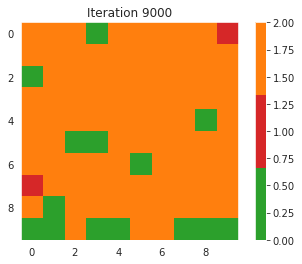

In [ ]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 2
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration 9000')
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

## Part 5: K-means and DBScan


In [ ]:
vectorizer = TfidfVectorizer()
comment_matrix_tf = vectorizer.fit_transform(train['comment_text'])

In [ ]:
print(f'BOW shape: {comment_matrix.shape}')
print(f'TF-IDF shape: {comment_matrix_tf.shape}')

BOW shape: (159571, 2167469)
TF-IDF shape: (159571, 176455)


In [ ]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
comment_svd_bow = svd.fit_transform(comment_matrix)
comment_svd_tf = svd.fit_transform(comment_matrix_tf)

In [ ]:
print(f'Sample rows from bow SVD: {comment_svd_bow[0:10]}')
print(f'Sample rows from TF-IDF SVD: {comment_svd_tf[0:10]}')

Sample rows from bow SVD: [[-1.28698492e-04 -2.13858885e-05]
 [-7.11099246e-07 -1.15877431e-07]
 [-8.15974281e-05 -1.51600469e-05]
 [-1.79599648e-03 -2.84455965e-04]
 [-2.51275407e-06 -4.09850644e-07]
 [-1.42978127e-05 -2.44459925e-06]
 [-4.42168944e-06 -1.42454517e-06]
 [-1.57510916e-04 -2.68315942e-05]
 [-1.00341760e-03 -1.57819069e-04]
 [-1.41212000e-05 -2.29537927e-06]]
Sample rows from TF-IDF SVD: [[ 0.18745034 -0.00274916]
 [ 0.06166889  0.00978931]
 [ 0.29751538 -0.0330366 ]
 [ 0.31533556 -0.00792062]
 [ 0.17839431  0.15056047]
 [ 0.12410062  0.00829572]
 [ 0.08256604  0.07862664]
 [ 0.23408391  0.13389635]
 [ 0.32952306 -0.0243804 ]
 [ 0.12058268 -0.02353744]]


In [ ]:
svd.explained_variance_ratio_

array([0.01226208, 0.00859771])

In [ ]:
kmeans_bow = KMeans(n_clusters=2, random_state=0).fit(comment_svd_bow)
kmeans_bow_labels = kmeans_bow.labels_
kmeans_tf = KMeans(n_clusters=2, random_state=0).fit(comment_svd_tf)
kmeans_tf_labels = kmeans_tf.labels_

In [ ]:
print(comment_svd_bow.shape)

(159571, 2)


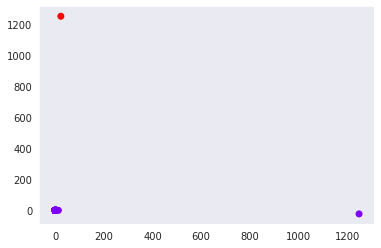

In [ ]:
plt.scatter(comment_svd_bow[:, 0], comment_svd_bow[:, 1], c=kmeans_bow_labels, cmap='rainbow')

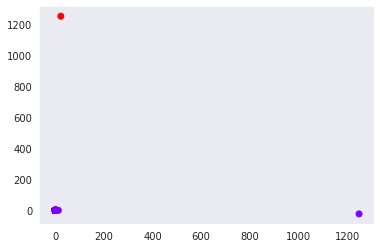

In [ ]:
plt.scatter(comment_svd_bow[:, 0], comment_svd_bow[:, 1], c=train['toxic'], cmap='rainbow')

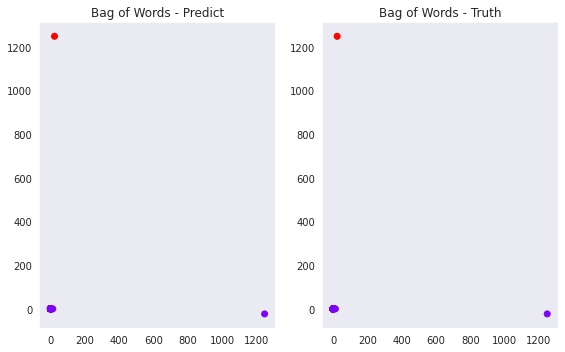

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].scatter(comment_svd_bow[:, 0], comment_svd_bow[:, 1], c=kmeans_bow_labels, cmap='rainbow')
axes[0].set_title('Bag of Words - Predict')
axes[1].scatter(comment_svd_bow[:, 0], comment_svd_bow[:, 1], c=train['toxic'], cmap='rainbow')
axes[1].set_title('Bag of Words - Truth')
fig.tight_layout()
plt.show()

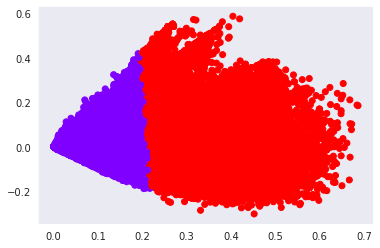

In [ ]:
plt.scatter(comment_svd_tf[:, 0], comment_svd_tf[:, 1], c=kmeans_tf_labels, cmap='rainbow')

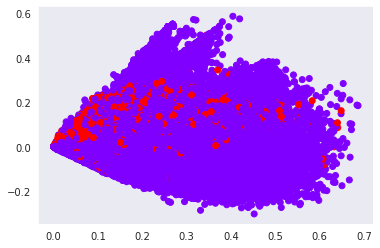

In [ ]:
plt.scatter(comment_svd_tf[:, 0], comment_svd_tf[:, 1], c=train['toxic'], cmap='rainbow')

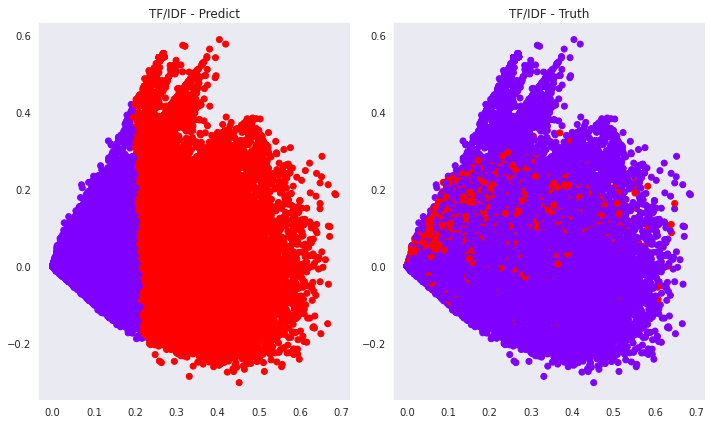

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].scatter(comment_svd_tf[:, 0], comment_svd_tf[:, 1], c=kmeans_tf_labels, cmap='rainbow')
axes[0].set_title('TF/IDF - Predict')
axes[1].scatter(comment_svd_tf[:, 0], comment_svd_tf[:, 1], c=train['toxic'], cmap='rainbow')
axes[1].set_title('TF/IDF - Truth')
fig.tight_layout()
plt.show()

Take a random sub sample of 20K points because 150K is too much

In [ ]:
n = len(comment_svd_bow)
comm_idxs = np.random.choice(n, size=20000, replace=False)
db_bow_labels = DBSCAN(eps=3, min_samples=3).fit_predict(comment_svd_bow[comm_idxs])

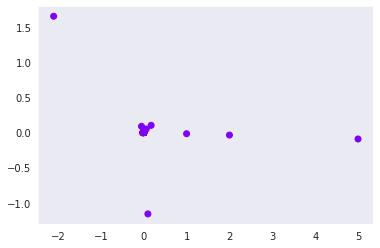

In [ ]:
x_plot = comment_svd_bow[comm_idxs]
x_plot = x_plot[:, 0]
y_plot = comment_svd_bow[comm_idxs][:, 1]
plt.scatter(x_plot, y_plot, c=db_bow_labels, cmap='rainbow')

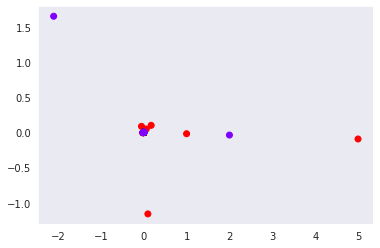

In [ ]:
plt.scatter(x_plot, y_plot, c=train['toxic'][comm_idxs], cmap='rainbow')

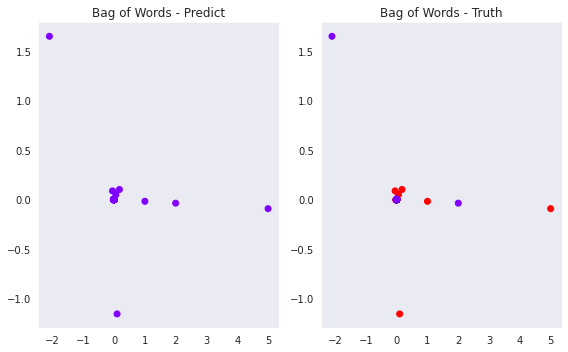

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].scatter(x_plot, y_plot, c=db_bow_labels, cmap='rainbow')
axes[0].set_title('Bag of Words - Predict')
axes[1].scatter(x_plot, y_plot, c=train['toxic'][comm_idxs], cmap='rainbow')
axes[1].set_title('Bag of Words - Truth')
fig.tight_layout()
plt.show()

In [ ]:
comm_idxs = np.random.choice(n, size=20000, replace=False)
db_tf_labels = DBSCAN(eps=3, min_samples=3).fit_predict(comment_svd_tf[comm_idxs])

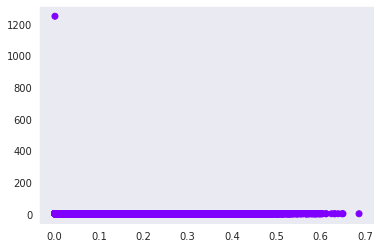

In [ ]:
x_plot2 = comment_svd_tf[comm_idxs]
x_plot2 = x_plot2[:, 0]
y_plot2 = comment_svd_bow[comm_idxs][:, 1]
plt.scatter(x_plot2, y_plot2, c=db_tf_labels, cmap='rainbow')

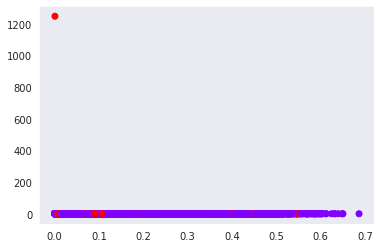

In [ ]:
plt.scatter(x_plot2, y_plot2, c=train['toxic'][comm_idxs], cmap='rainbow')

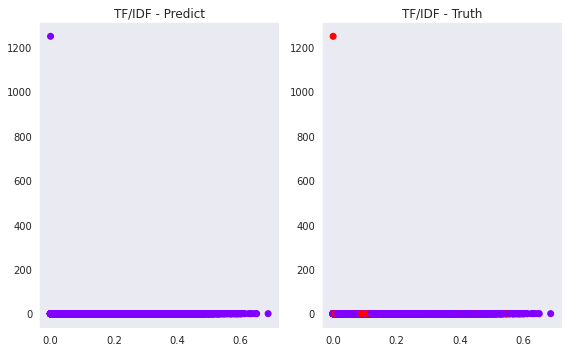

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].scatter(x_plot2, y_plot2, c=db_tf_labels, cmap='rainbow')
axes[0].set_title('TF/IDF - Predict')
axes[1].scatter(x_plot2, y_plot2, c=train['toxic'][comm_idxs], cmap='rainbow')
axes[1].set_title('TF/IDF - Truth')
fig.tight_layout()
plt.show()

## Part 6: Metrics!

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import davies_bouldin_score

In [ ]:
dbscan_truth = train['toxic'][comm_idxs]
print(np.unique(dbscan_truth))
print(np.unique(db_bow_labels))
db_bow_labels_norm = np.where(db_bow_labels == -1, 1, db_bow_labels)
print(np.unique(db_bow_labels_norm))
print(np.unique(db_tf_labels))
print(db_tf_labels)

[0 1]
[0]
[0]
[0]
[0 0 0 ... 0 0 0]


In [ ]:
f1_kmeans_bow = f1_score(train['toxic'], kmeans_bow_labels)
print(f'F1 Score K means BOW {f1_kmeans_bow} ')
f1_kmeans_tf = f1_score(train['toxic'], kmeans_tf_labels)
print(f'F1 Score K means TF/IDF {f1_kmeans_tf} ')
f1_dbscan_bow = f1_score(dbscan_truth, db_bow_labels)
print(f'F1 Score DBScan BOW {f1_dbscan_bow} ')
f1_dbscan_tf = f1_score(dbscan_truth, db_tf_labels)
print(f'F1 Score DBScan TF/IDF {f1_dbscan_tf} ')

F1 Score K means BOW 0.00013076168682576005 
F1 Score K means TF/IDF 0.08893108632012027 
F1 Score DBScan BOW 0.0 
F1 Score DBScan TF/IDF 0.0 


In [ ]:
'''
ss_kmeans_bow = silhouette_score(comment_svd_bow, kmeans_bow_labels, metric='euclidean', sample_size=300)
print(f'Silhoutte Score K means BOW {ss_kmeans_bow} ')
ss_kmeans_tf = silhouette_score(comment_svd_tf, kmeans_tf_labels, metric='euclidean', sample_size=300)
print(f'Silhoutte Score K means TF/IDF {ss_kmeans_tf} ')
ss_dbscan_bow = silhouette_score(comment_svd_bow[comm_idxs], db_bow_labels, metric='euclidean', sample_size=300)
print(f'Silhoutte Score DBScan BOW {ss_dbscan_bow} ')
ss_dbscan_tf = silhouette_score(comment_svd_tf[comm_idxs], db_tf_labels, metric='euclidean', sample_size=300)
print(f'F1 Score DBScan TF/IDF {ss_dbscan_tf} ')
'''

"\nss_kmeans_bow = silhouette_score(comment_svd_bow, kmeans_bow_labels, metric='euclidean', sample_size=300)\nprint(f'Silhoutte Score K means BOW {ss_kmeans_bow} ')\nss_kmeans_tf = silhouette_score(comment_svd_tf, kmeans_tf_labels, metric='euclidean', sample_size=300)\nprint(f'Silhoutte Score K means TF/IDF {ss_kmeans_tf} ')\nss_dbscan_bow = silhouette_score(comment_svd_bow[comm_idxs], db_bow_labels, metric='euclidean', sample_size=300)\nprint(f'Silhoutte Score DBScan BOW {ss_dbscan_bow} ')\nss_dbscan_tf = silhouette_score(comment_svd_tf[comm_idxs], db_tf_labels, metric='euclidean', sample_size=300)\nprint(f'F1 Score DBScan TF/IDF {ss_dbscan_tf} ')\n"

In [ ]:
f1_kmeans_bow = normalized_mutual_info_score(train['toxic'], kmeans_bow_labels)
print(f'NMI Score K means BOW {f1_kmeans_bow} ')
f1_kmeans_tf = normalized_mutual_info_score(train['toxic'], kmeans_tf_labels)
print(f'NMI Score K means TF/IDF {f1_kmeans_tf} ')
f1_dbscan_bow = normalized_mutual_info_score(dbscan_truth, db_bow_labels_norm)
print(f'NMI Score DBScan BOW {f1_dbscan_bow} ')
f1_dbscan_tf = normalized_mutual_info_score(dbscan_truth, db_tf_labels)
print(f'NMI Score DBScan TF/IDF {f1_dbscan_tf} ')

NMI Score K means BOW 9.303143130680961e-05 
NMI Score K means TF/IDF 0.01246465017691062 
NMI Score DBScan BOW 0.0 
NMI Score DBScan TF/IDF 0.0 


In [ ]:
f1_kmeans_bow = fowlkes_mallows_score(train['toxic'], kmeans_bow_labels)
print(f'FM Score K means BOW {f1_kmeans_bow} ')
f1_kmeans_tf = fowlkes_mallows_score(train['toxic'], kmeans_tf_labels)
print(f'FM Score K means TF/IDF {f1_kmeans_tf} ')
f1_dbscan_bow = fowlkes_mallows_score(dbscan_truth, db_bow_labels)
print(f'FM Score DBScan BOW {f1_dbscan_bow} ')
f1_dbscan_tf = fowlkes_mallows_score(dbscan_truth, db_tf_labels)
print(f'FM Score DBScan TF/IDF {f1_dbscan_tf} ')

FM Score K means BOW 0.9092250748092744 
FM Score K means TF/IDF 0.653775457592551 
FM Score DBScan BOW 0.9075248233879079 
FM Score DBScan TF/IDF 0.9075248233879079 


In [ ]:
'''
ss_kmeans_bow = davies_bouldin_score(comment_svd_bow, kmeans_bow_labels)
print(f'Davies Bouldin Score K means BOW {ss_kmeans_bow} ')
ss_kmeans_tf = davies_bouldin_score(comment_svd_tf, kmeans_tf_labels)
print(f'Davies Bouldin Score K means TF/IDF {ss_kmeans_tf} ')
ss_dbscan_bow = davies_bouldin_score(comment_svd_bow[comm_idxs], db_bow_labels)
print(f'Davies Bouldin Score DBScan BOW {ss_dbscan_bow} ')
ss_dbscan_tf = davies_bouldin_score(comment_svd_tf[comm_idxs], db_tf_labels)
print(f'Davies Bouldin Score DBScan TF/IDF {ss_dbscan_tf} ')
'''

"\nss_kmeans_bow = davies_bouldin_score(comment_svd_bow, kmeans_bow_labels)\nprint(f'Davies Bouldin Score K means BOW {ss_kmeans_bow} ')\nss_kmeans_tf = davies_bouldin_score(comment_svd_tf, kmeans_tf_labels)\nprint(f'Davies Bouldin Score K means TF/IDF {ss_kmeans_tf} ')\nss_dbscan_bow = davies_bouldin_score(comment_svd_bow[comm_idxs], db_bow_labels)\nprint(f'Davies Bouldin Score DBScan BOW {ss_dbscan_bow} ')\nss_dbscan_tf = davies_bouldin_score(comment_svd_tf[comm_idxs], db_tf_labels)\nprint(f'Davies Bouldin Score DBScan TF/IDF {ss_dbscan_tf} ')\n"